In [ ]:
import pandas as pd
import numpy as np
import math
import re
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Sotfcomputing/Assignment 3/Dataset 1.csv', encoding = "ISO-8859-1", engine='python')

# Preprocessing

In [ ]:
# removing mentions, links, tags

import re

def preprocessing(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)     # removing @mentions
    text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)  # removing @mentions 
    text = re.sub(r'@[A-Za-z]+', '', text)        # removing @mentions
    text = re.sub(r'@[-)]+', '', text)            # removing @mentions
    text = re.sub(r'https?\/\/\S+', '', text)     # removing the hyper link
    text = re.sub(r'http?\/\/\S+', '', text)     # removing the hyper link
    text = re.sub(r'#', '', text )              # removing '#' sign
    text = re.sub(r'RT[\s]+', '', text)         # removing RT
    text = re.sub(r'&[a-z;]+', '', text)        # removing '&gt;'
    return text



In [ ]:
df['message'] = df['message'].apply(preprocessing)

In [ ]:
df.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,http://twitpic.com/2y2lx - http://www.youtube...,0
3,Need to send 'em to my accountant tomorrow. O...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


## Vectorization

In [ ]:
dataset = df
unique_label = np.unique(df["label"])
num_classes = len(unique_label)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['message'].values, pd.get_dummies(dataset['label']).values, test_size=0.20)

tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
word_index = tokenizer.word_index

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)
pad_train = pad_sequences(train_seq, maxlen=100)
pad_test = pad_sequences(test_seq, maxlen=100)



## Model

In [ ]:
model = Sequential()
model.add(Embedding(25000, 100, input_length=pad_train.shape[1]))
model.add(LSTM(100, activation= 'tanh', return_sequences=True))
model.add(LSTM(100, activation= 'tanh', return_sequences=True))
model.add(LSTM(100, activation= 'tanh'))
model.add(Dense(2, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

epochs = 10
batch_size = 64

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2500000   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 100)          80400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 2,741,402
Trainable params: 2,741,402
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(pad_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
129/129 [==============================] - 21s 87ms/step - loss: 0.2432 - accuracy: 0.9098
Epoch 2/10
129/129 [==============================] - 11s 82ms/step - loss: 0.0145 - accuracy: 0.9975
Epoch 3/10
129/129 [==============================] - 10s 79ms/step - loss: 0.0511 - accuracy: 0.9920
Epoch 4/10
129/129 [==============================] - 10s 78ms/step - loss: 0.0084 - accuracy: 0.9984
Epoch 5/10
129/129 [==============================] - 10s 75ms/step - loss: 0.0051 - accuracy: 0.9994
Epoch 6/10
129/129 [==============================] - 9s 72ms/step - loss: 0.0043 - accuracy: 0.9995
Epoch 7/10
129/129 [==============================] - 9s 70ms/step - loss: 0.0038 - accuracy: 0.9993
Epoch 8/10
129/129 [==============================] - 9s 69ms/step - loss: 0.0034 - accuracy: 0.9996
Epoch 9/10
129/129 [==============================] - 9s 70ms/step - loss: 0.0031 - accuracy: 0.9995
Epoch 10/10
129/129 [==============================] - 9s 69ms/step - loss: 0.0029 - a

In [ ]:
evaluation = model.evaluate(pad_test,y_test)
accuracy = evaluation[1] * 100
print("Accuracy is : ", accuracy)

65/65 [==============================] - 3s 29ms/step - loss: 0.0340 - accuracy: 0.9942
Accuracy is :  99.41832423210144


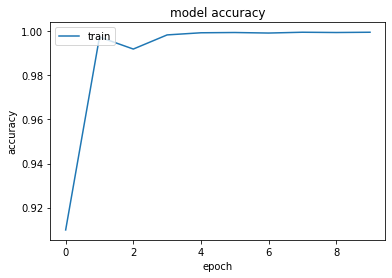

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

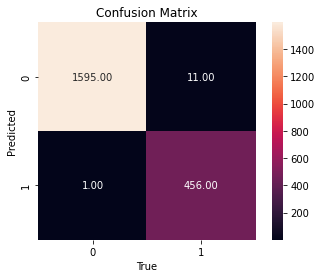

In [ ]:
y_pred = model.predict(pad_test)

new_y_pred = np.argmax(y_pred, axis=1)
new_y_test = np.argmax(y_test, axis=1)

conf_arr = np.zeros((num_classes, num_classes))

for i in range(len(new_y_pred)):
        conf_arr[new_y_pred[i]][new_y_test[i]] += 1

df_cm = pd.DataFrame(conf_arr, index = unique_label, columns = unique_label)



fig = plt.figure()
plt.clf()

ax = fig.add_subplot()
ax.set_aspect(1)

res = sb.heatmap(df_cm, annot=True, fmt='.2f')

plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()

In [ ]:
print(classification_report(new_y_test, new_y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1596
           1       1.00      0.98      0.99       467

    accuracy                           0.99      2063
   macro avg       1.00      0.99      0.99      2063
weighted avg       0.99      0.99      0.99      2063



In [ ]:
precision =   precision_score(new_y_test, new_y_pred) * 100
recall =  recall_score(new_y_test, new_y_pred) * 100
f1_score =  f1_score(new_y_test, new_y_pred) * 100
print(precision)
print(f1_score)
print(recall)

99.78118161925602
98.7012987012987
97.64453961456103


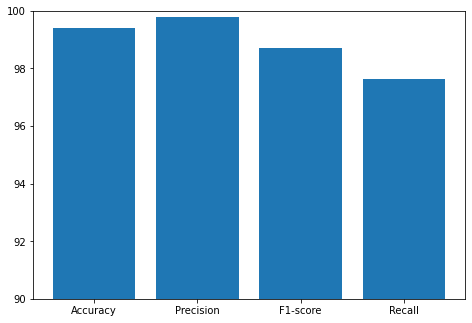

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
label = ['Accuracy', 'Precision', 'F1-score', 'Recall']
value = [accuracy,precision,f1_score,recall]
ax.bar(label,value)
plt.ylim(90,100)
plt.show()